# <center>Predicting Short Term Stock Price Movements</center>

Spring 2025 Data Science Project

Authors and Contributions:


- Arman Dashtipour: Project Idea …


- Gregory Seleznev: Project Idea, Dataset Curation & Preprocessing (Combining data sources, feature extraction & creation), Data Exploration (Pre-Tax Profit VS ROA & Ratio Changes vs Stock Price Changes), Stock return smoothing, ML Design (Simple approach version).


- Shankar Soma: Project Idea, Exploratory Data Analysis (basic data overview, number of features & entries, missing values, feature over-representation, feature count visualizations, correlation matrix, outlier detection, monthly volume trends), ML LSTM model with attention developed for short term change predictions.


- Shashank Thirumale: Project Idea. Data Exploration (Which industry has grown the most and Relationship between Debt to Equity Ratio and Return on Equity) performed Hypothesis test for these observations. Performed hypothesis test to show model performance in relation to randomly guessing, and wrote insights and conclusions that can be made about the model’s performance.


- Thomas Zhong: Project Idea, Introduction, Dataset Curation & Preprocessing, Data Exploration and Summary Statistics (Risk Adjusted Metrics across industries, including Sharpe, Rolling Sharpe, and Max Drawdown vs Average Return), Hypothesis Testing, Final Tutorial Report Creation.






# Introduction
### Why is money important?
Wealth is much more than a number in a bank account, it represents quality of life, social status, and being in control of your life. People work all their lives in the pursuit of having more money and being wealthier.

### Why stocks?
The stock market is one of the largest and most lucrative markets in the world. If someone could consistently and accurately predict price movements and capitalize off it, it would be possible to near infinitely multiply their money. Unfortunately, it's not as simple as that. The stock market is constantly growing and evolving to be more and more efficient, while firms spend billions trying to gain the slightest edge over the market. 

### Our Work
In this project, we aim to gain some predictive power over short term price movements in the stock market. It's impossible to consistently win every trade, but any edge over the market can be extremely powerful. If we can predict whether a stock will go up or down with greater than 50% acuracy, even by a small margin, we can leverage this statistical edge and open up the potential to generate positive returns. Our goal is to create an advantage for us that can lead to meaningful results in the market.

Let's begin by installing the required packages and importing the necessary libraries!

In [2]:
# Uncomment the below line if you need to install the packages
# %pip install pandas matplotlib numpy yfinance scipy pandas-ta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os
import time
import scipy.stats as stats
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 2000)

# Data Curation

The datasets used in this project are as follows:
-  iShares Core S&P ETF (https://www.ishares.com/us/products/239726/ishares-core-sp-500-etf) 
   
An official list of all companies in the S&P500 index, including their name, ticker, and sector.
-  Stock Data and Ratios from HuggingFace (https://huggingface.co/datasets/pmoe7/SP_500_Stocks_Data-ratios_news_price_10_yrs)  
  
Historical financial data for S&P500 companies over the past 10 years, including prices and financial ratios.

These two lines load CSV files of the datasets into pandas DataFrames:

In [3]:
# get the dataframes
ratio_df = pd.read_csv("sp500_daily_ratios_20yrs.csv")
sp500_info_df = pd.read_csv("sp500_info.csv")

### Data Preprocessing
We start by converting the Date column to proper datetime format. Then, we match tickers between the two datasets so we can add Sector and Industry information from sp500_info_df to our main ratio_df. After inserting the new columns, we loop through the common tickers and fill in the corresponding sector values. Finally, we keep only the rows with known sectors to ensure cleaner analysis.

In [4]:
# convert date column to datetime
ratio_df["Date"] = pd.to_datetime(ratio_df["Date"])


### Preprocessing: Find Common Tickers Between sp500_info and sp500_daily_ratios

In [5]:
# convert date column to datetime
ratio_df["Date"] = pd.to_datetime(ratio_df["Date"])
# add sector to dataframe

# the ratios df has missing tickers so we need to find the ones that are common between sp500_info and sp500_daily_ratios
tickers1 = ratio_df["Ticker"].unique()
tickers2 = sp500_info_df["Symbol"].unique()

tickers_in_both_dfs = np.intersect1d(tickers1, tickers2)
print(f"There are {len(tickers_in_both_dfs)} tickers that we can analyze with known Sector value")

# we want to add two new features: sector and industry
ratio_df.insert(1, "Sector", None)
ratio_df.insert(2, "Industry", None)


for ticker in tickers_in_both_dfs:
    sector = sp500_info_df[sp500_info_df["Symbol"] == ticker]["Sector"].iloc[0]
    ratio_df.loc[ratio_df["Ticker"] == ticker, "Sector"] = sector

# Only keep rows with known sector. this removes ~40 tickers, might need to remove this later
ratio_df = ratio_df.dropna(subset=["Sector"])

There are 280 tickers that we can analyze with known Sector value


We create this map_sector_to_industry function to group detailed industry categories into broader, more manageable industry sectors. This helps simplify our analysis by reducing dozens of specific industry labels (like "Semiconductors" or "Health Care Equipment") into higher-level groups (like "Technology & Software" or "Health Care & Life Sciences"), making trends and comparisons easier to interpret.

In [6]:
def map_sector_to_industry(sector):
    industry_map = {
        # Technology & Software
        "Application Software": "Technology & Software",
        "Systems Software": "Technology & Software",
        "Internet Services & Infrastructure": "Technology & Software",
        "Interactive Media & Services": "Technology & Software",
        "Interactive Home Entertainment": "Technology & Software",
        "Communications Equipment": "Technology & Software",
        "Technology Hardware, Storage & Peripherals": "Technology & Software",
        "Technology Distributors": "Technology & Software",
        "IT Consulting & Other Services": "Technology & Software",
        "Data Processing & Outsourced Services": "Technology & Software",
        "Financial Exchanges & Data": "Technology & Software",
        "Semiconductor Materials & Equipment": "Technology & Software",
        "Semiconductors": "Technology & Software",
        "Electronic Components": "Technology & Software",
        "Electronic Equipment & Instruments": "Technology & Software",

        # Health Care & Life Sciences
        "Biotechnology": "Health Care & Life Sciences",
        "Health Care Equipment": "Health Care & Life Sciences",
        "Health Care Services": "Health Care & Life Sciences",
        "Health Care Distributors": "Health Care & Life Sciences",
        "Managed Health Care": "Health Care & Life Sciences",
        "Pharmaceuticals": "Health Care & Life Sciences",
        "Health Care Supplies": "Health Care & Life Sciences",
        "Life Sciences Tools & Services": "Health Care & Life Sciences",
        "Health Care Facilities": "Health Care & Life Sciences",

        # Financial Services
        "Diversified Banks": "Financial Services",
        "Regional Banks": "Financial Services",
        "Asset Management & Custody Banks": "Financial Services",
        "Investment Banking & Brokerage": "Financial Services",
        "Insurance Brokers": "Financial Services",
        "Life & Health Insurance": "Financial Services",
        "Multi-line Insurance": "Financial Services",
        "Property & Casualty Insurance": "Financial Services",
        "Consumer Finance": "Financial Services",

        # Energy & Utilities
        "Electric Utilities": "Energy & Utilities",
        "Multi-Utilities": "Energy & Utilities",
        "Gas Utilities": "Energy & Utilities",
        "Water Utilities": "Energy & Utilities",
        "Independent Power Producers & Energy Traders": "Energy & Utilities",
        "Integrated Oil & Gas": "Energy & Utilities",
        "Oil & Gas Equipment & Services": "Energy & Utilities",
        "Oil & Gas Exploration & Production": "Energy & Utilities",
        "Oil & Gas Refining & Marketing": "Energy & Utilities",
        "Oil & Gas Storage & Transportation": "Energy & Utilities",

        # Consumer Goods
        "Household Products": "Consumer Goods",
        "Personal Care Products": "Consumer Goods",
        "Tobacco": "Consumer Goods",
        "Packaged Foods & Meats": "Consumer Goods",
        "Soft Drinks & Non-alcoholic Beverages": "Consumer Goods",
        "Consumer Electronics": "Consumer Goods",
        "Home Furnishings": "Consumer Goods",

        # Retail
        "Broadline Retail": "Retail",
        "Automotive Retail": "Retail",
        "Consumer Staples Merchandise Retail": "Retail",
        "Computer & Electronics Retail": "Retail",
        "Food Retail": "Retail",
        "Home Improvement Retail": "Retail",
        "Restaurants": "Retail",

        # Real Estate (REITs)
        "Hotel & Resort REITs": "Real Estate (REITs)",
        "Multi-Family Residential REITs": "Real Estate (REITs)",
        "Office REITs": "Real Estate (REITs)",
        "Retail REITs": "Real Estate (REITs)",
        "Self-Storage REITs": "Real Estate (REITs)",
        "Data Center REITs": "Real Estate (REITs)",
        "Telecom Tower REITs": "Real Estate (REITs)",
        "Other Specialized REITs": "Real Estate (REITs)",

        # Industrials & Manufacturing
        "Aerospace & Defense": "Industrials & Manufacturing",
        "Industrial Conglomerates": "Industrials & Manufacturing",
        "Industrial Gases": "Industrials & Manufacturing",
        "Industrial Machinery & Supplies & Components": "Industrials & Manufacturing",
        "Electrical Components & Equipment": "Industrials & Manufacturing",
        "Construction Machinery & Heavy Transportation Equipment": "Industrials & Manufacturing",
        "Building Products": "Industrials & Manufacturing",
        "Construction Materials": "Industrials & Manufacturing",
        "Fertilizers & Agricultural Chemicals": "Industrials & Manufacturing",
        "Specialty Chemicals": "Industrials & Manufacturing",
        "Paper & Plastic Packaging Products & Materials": "Industrials & Manufacturing",
        "Trading Companies & Distributors": "Industrials & Manufacturing",
        "Distributors": "Industrials & Manufacturing",

        # Transportation & Logistics
        "Air Freight & Logistics": "Transportation & Logistics",
        "Cargo Ground Transportation": "Transportation & Logistics",
        "Rail Transportation": "Transportation & Logistics",
        "Passenger Airlines": "Transportation & Logistics",

        # Automotive
        "Automobile Manufacturers": "Automotive",
        "Automotive Parts & Equipment": "Automotive",

        # Media, Entertainment & Leisure
        "Movies & Entertainment": "Media, Entertainment & Leisure",
        "Casinos & Gaming": "Media, Entertainment & Leisure",
        "Hotels, Resorts & Cruise Lines": "Media, Entertainment & Leisure",
        "Leisure Products": "Media, Entertainment & Leisure",
        "Advertising": "Media, Entertainment & Leisure",

        # Telecommunications
        "Cable & Satellite": "Telecommunications",

        # Agriculture
        "Agricultural Products & Services": "Agriculture",
        "Agricultural & Farm Machinery": "Agriculture",

        # Real Estate Services & Consulting
        "Real Estate Services": "Real Estate Services & Consulting",
        "Research & Consulting Services": "Real Estate Services & Consulting",
        "Human Resource & Employment Services": "Real Estate Services & Consulting",
        "Diversified Support Services": "Real Estate Services & Consulting",

        # Materials & Natural Resources
        "Gold": "Materials & Natural Resources",
        "Copper": "Materials & Natural Resources",

        # Miscellaneous
        "Transaction & Payment Processing Services": "Miscellaneous",
        "Construction & Engineering": "Miscellaneous",
        "Homebuilding": "Miscellaneous"
    }

    return industry_map.get(sector)

In [7]:
def display_group(groups_df):
    for name, group in groups_df:
        print(f"{name}:")
        display(group)

In [8]:
# map sector to a broader industry
ratio_df["Industry"] = ratio_df["Sector"].apply(map_sector_to_industry)

# All stocks now have an industry. good.
ratio_df["Industry"].isna().any()

np.False_

### Removing missing gaps and empty columns in the time series
We handle missing data by identifying and removing large gaps in the time series. First, we calculate daily percentage change in stock price (Change) for each ticker, and drop rows where that can't be computed. Then, we find cases where more than 5 days passed between two trading dates for the same ticker — which indicates missing data. For each of those cases, we remove all earlier rows for that ticker to ensure our analysis starts after the gap. Finally, we drop the first row for each ticker (which lacks a previous date for comparison).

In [9]:
# Problem: there are gaps in the rows where there is up to 300 days between the next day.
# We need to drop these rows before gap because too much data is missing.

# calcualte the day change (in percent) for each stock
ratio_df['Change'] = ratio_df.groupby('Ticker')['Close'].pct_change() * 100
# drop the NaN changes (day 0)
ratio_df.dropna(subset=["Change"])

# find rows that are over 5 days after the previous row for each ticker
ratio_df['Prev_Date'] = ratio_df.groupby('Ticker')['Date'].shift(1)
ratio_df['Days_Diff'] = (ratio_df['Date'] - ratio_df['Prev_Date']).dt.days
over_a_month = ratio_df[ratio_df['Days_Diff'] > 5]

# date for each ticker when gap ended
dates = {}

for index, row in over_a_month.iterrows():
    dates[row['Ticker']] = row['Date'] + pd.Timedelta(days=1)

for ticker, date in dates.items():
    ratio_df = ratio_df[(ratio_df['Ticker'] != ticker) | (ratio_df['Date'] >= date)]

# drop the first day where there is no day difference
ratio_df = ratio_df.dropna(subset=['Days_Diff'])

# Look for columns with unusually low unique values
for column in ratio_df.columns:
    unique_values = ratio_df[column].unique()
    print(f"Column: {column}, Unique numbers: {unique_values.size}")

ratio_df.drop(columns=["EBITDA Margin"], inplace=True)

Column: Ticker, Unique numbers: 280
Column: Sector, Unique numbers: 101
Column: Industry, Unique numbers: 16
Column: Date, Unique numbers: 3132
Column: Open, Unique numbers: 43827
Column: Close, Unique numbers: 44479
Column: Volume, Unique numbers: 120728
Column: quarter, Unique numbers: 4
Column: year, Unique numbers: 13
Column: Asset Turnover, Unique numbers: 3293
Column: Current Ratio, Unique numbers: 5395
Column: Days Sales In Receivables, Unique numbers: 5866
Column: Debt/Equity Ratio, Unique numbers: 5784
Column: EBIT Margin, Unique numbers: 6499
Column: EBITDA Margin, Unique numbers: 1
Column: Gross Margin, Unique numbers: 5670
Column: Inventory Turnover Ratio, Unique numbers: 4292
Column: Long-term Debt / Capital, Unique numbers: 4486
Column: Net Profit Margin, Unique numbers: 6785
Column: Operating Margin, Unique numbers: 6502
Column: Pre-Tax Profit Margin, Unique numbers: 6809
Column: ROA - Return On Assets, Unique numbers: 4550
Column: ROE - Return On Equity, Unique numbers:

# Exploratory Data Analysis and Summary Statistics
We will explore the data and summarize the statistics of the data to help us understand the data better. 

The main aspects of the data that we will explore are:
- Main characteristics of the data
- Number of features and entries
- Over-representation of a feature
- Feaure correlation
- Outliers & missing values

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 432845 entries, 1953 to 1048574
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Ticker                     432845 non-null  object        
 1   Sector                     432845 non-null  object        
 2   Industry                   432845 non-null  object        
 3   Date                       432845 non-null  datetime64[ns]
 4   Open                       432845 non-null  float64       
 5   Close                      432845 non-null  float64       
 6   Volume                     432845 non-null  int64         
 7   quarter                    432845 non-null  int64         
 8   year                       432845 non-null  int64         
 9   Asset Turnover             432845 non-null  float64       
 10  Current Ratio              432845 non-null  float64       
 11  Days Sales In Receivables  432845 non-n

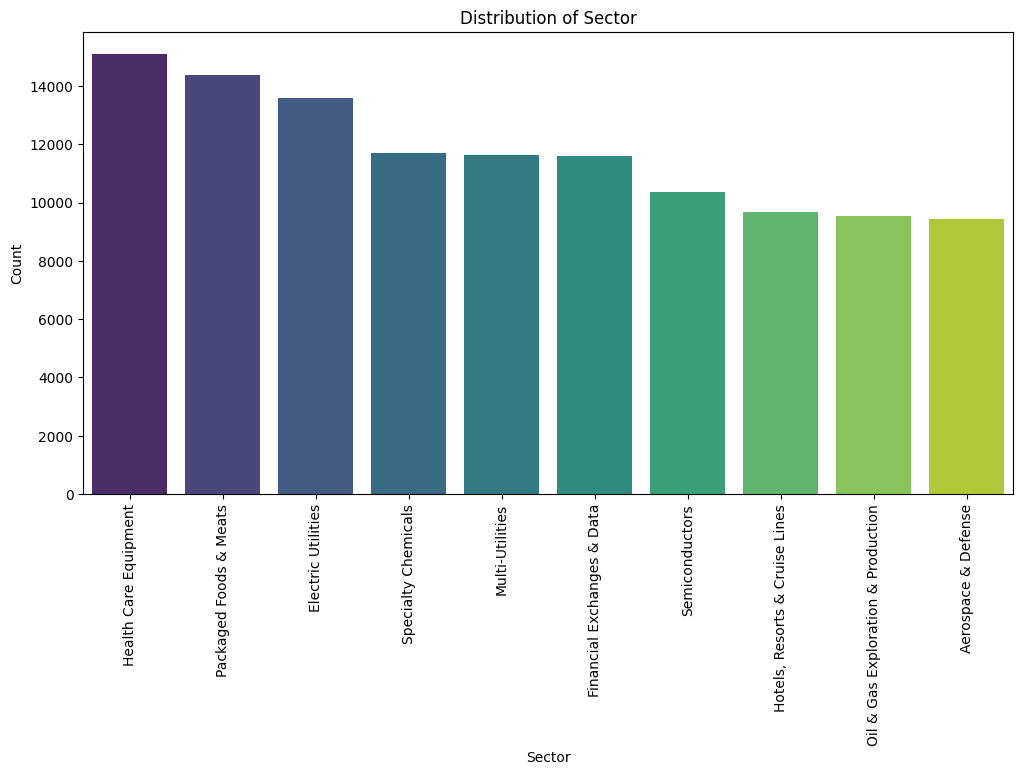


Industry Distribution:
Industry
Technology & Software             71547
Industrials & Manufacturing       64079
Health Care & Life Sciences       56705
Energy & Utilities                51731
Financial Services                47007
Consumer Goods                    29477
Retail                            22650
Real Estate (REITs)               22650
Media, Entertainment & Leisure    20259
Transportation & Logistics        10570
Name: count, dtype: int64


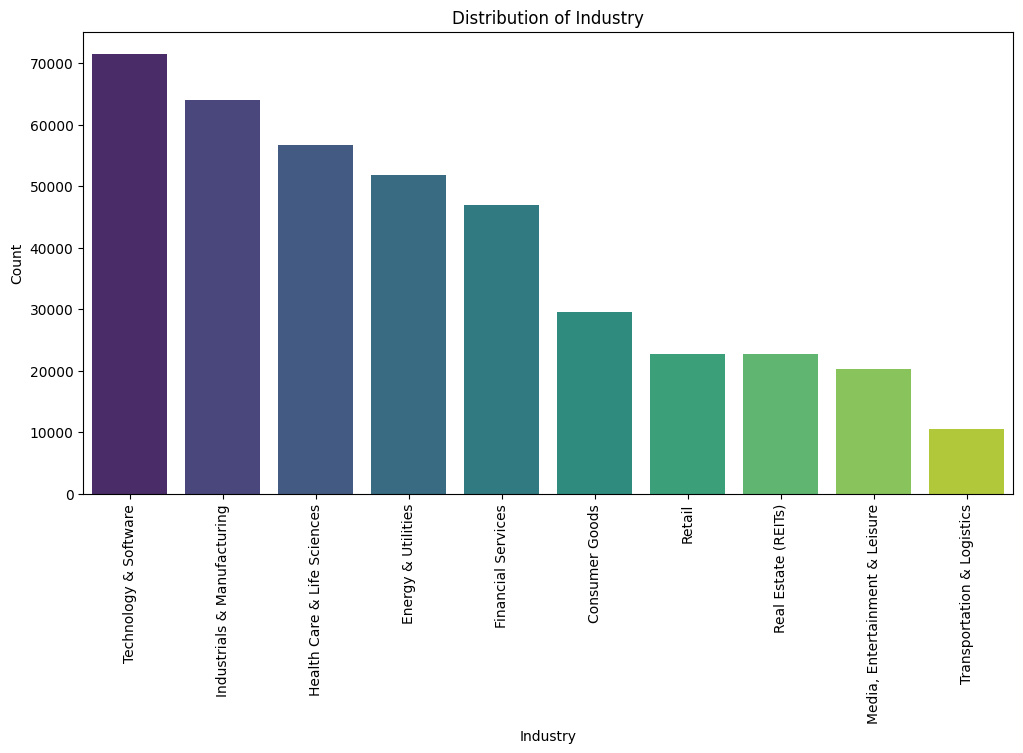

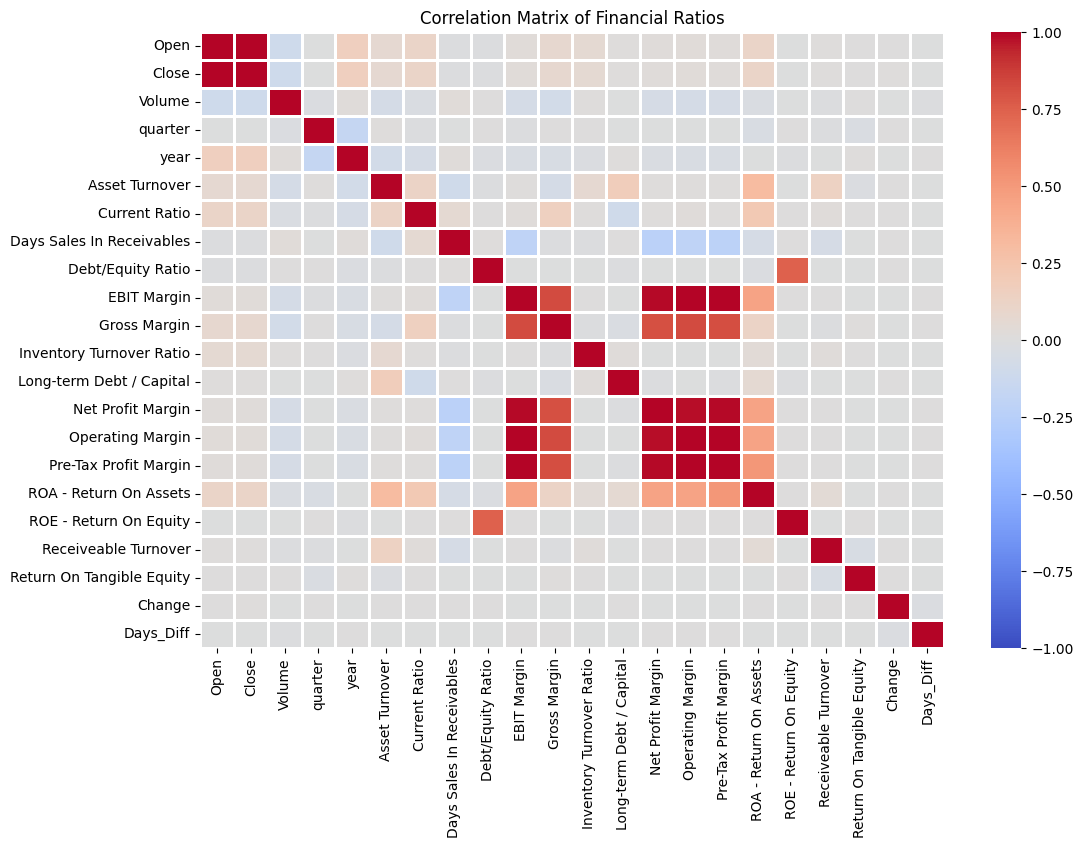

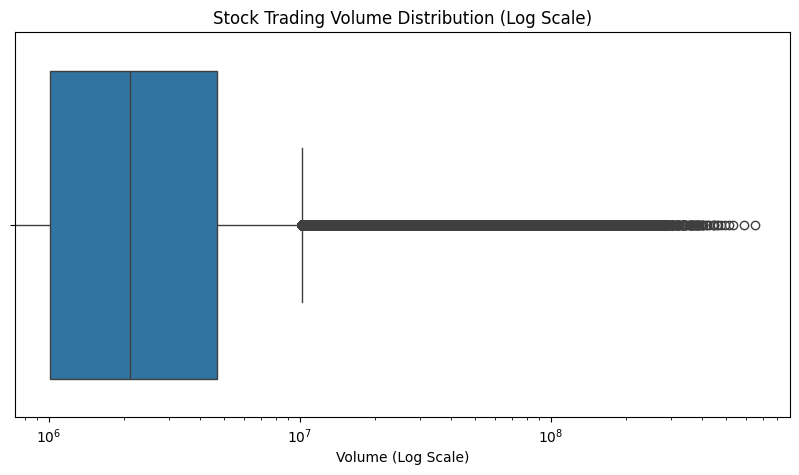


Outliers in Volume (43819 points):
        Ticker                                      Sector  \
2863         A              Life Sciences Tools & Services   
3114         A              Life Sciences Tools & Services   
12218     AAPL  Technology Hardware, Storage & Peripherals   
12219     AAPL  Technology Hardware, Storage & Peripherals   
12220     AAPL  Technology Hardware, Storage & Peripherals   
...        ...                                         ...   
1048374     NI                             Multi-Utilities   
1048500     NI                             Multi-Utilities   
1048501     NI                             Multi-Utilities   
1048505     NI                             Multi-Utilities   
1048545     NI                             Multi-Utilities   

                            Industry       Date   Open  Close     Volume  \
2863     Health Care & Life Sciences 2018-05-15  60.50  61.14   14451200   
3114     Health Care & Life Sciences 2019-05-15  66.50  66.77   145

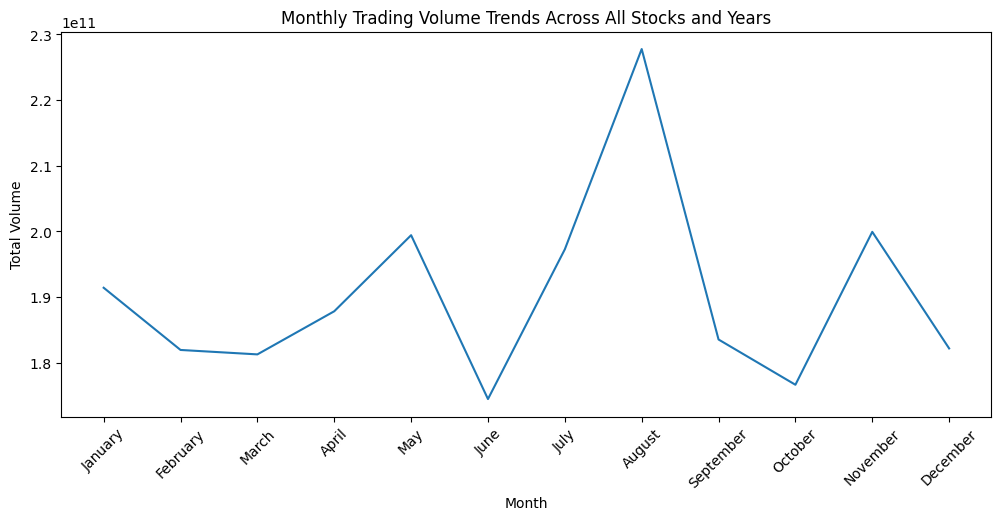

In [10]:
# Basic Data Overview
print("Dataset Info:")
print(ratio_df.info())
print("\nBasic Statistics:")
print(ratio_df.describe())

# Number of Features and Entries
num_entries, num_features = ratio_df.shape
print(f"Number of entries: {num_entries}, Number of features: {num_features}")

# Check for missing values
missing_values = ratio_df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])

# Feature Over-representation
categorical_features = ["Sector", "Industry"] 
for feature in categorical_features:
    feature_counts = ratio_df[feature].value_counts()
    print(f"\n{feature} Distribution:")
    print(feature_counts.head(10))  # Displaying top 10 for readability
    
    # Visualization
    plt.figure(figsize=(12, 6))
    sns.barplot(x=feature_counts.index[:10], y=feature_counts.values[:10], palette='viridis', hue=feature_counts.index[:10])
    plt.xticks(rotation=90)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(f"Distribution of {feature}")
    plt.show()

# Correlation Matrix
correlation_matrix = ratio_df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, linewidths=1, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Financial Ratios")
plt.show()

# Outlier Detection - Volume
plt.figure(figsize=(10, 5))
sns.boxplot(x=ratio_df["Volume"])
plt.xscale("log")  # Log scale for better visualization
plt.xlabel("Volume (Log Scale)")
plt.title("Stock Trading Volume Distribution (Log Scale)")
plt.show()

# Print out the points with a Volume greater than 10^7 (outlier threshold based on boxplot)
outliers = ratio_df[ratio_df["Volume"] > 1e7]
print(f"\nOutliers in Volume ({len(outliers)} points):")
print(outliers)

# Finding Date Ranges
print("\nDate Range:")
print(f"Start Date: {ratio_df['Date'].min()}, End Date: {ratio_df['Date'].max()}")

# Biggest Volume Day
max_volume_day = ratio_df.loc[ratio_df['Volume'].idxmax()]
print("\nHighest Trading Volume Day:")
print(max_volume_day)

# Lowest Volume Day
min_volume_day = ratio_df.loc[ratio_df['Volume'].idxmin()]
print("\nLowest Trading Volume Day:")
print(min_volume_day)

# Monthly Volume Trends Over Each Month
month_map = {
    1 : "January",
    2 : "February",
    3 : "March",
    4 : "April",
    5 : "May",
    6 : "June",
    7 : "July",
    8 : "August",
    9 : "September",
    10 : "October",
    11 : "November",
    12 : "December"
}

# Plot monthly volume trends across all stocks and years
ratio_df["Month"] = ratio_df["Date"].dt.month.map(month_map)
monthly_volume = ratio_df.groupby("Month")["Volume"].sum()
plt.figure(figsize=(12, 5))
sns.lineplot(x=monthly_volume.index.astype(str), y=monthly_volume.values)
plt.xticks(rotation=45, labels=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ticks=range(0, 12))
plt.xlabel("Month")
plt.ylabel("Total Volume")
plt.title("Monthly Trading Volume Trends Across All Stocks and Years")
plt.show()

### Is there a relationship between the Debt-Equity Ratio and Return on Equity?

We use linear regression to analyze the relationship between a company’s Debt/Equity Ratio and its Return on Equity (ROE). After isolating the debt/equity ratio and ROE from the data, we fit a simple regression model and visualize the best-fit line over the data points. We then evaluate the strength of the relationship using the R-squared value, and perform a hypothesis test on the slope to determine if the relationship is statistically significant. Finally, we print the slope, t-statistic, p-value, and conclude whether or not to reject the null hypothesis based on an alpha level of 0.05.

c:\Users\zhong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


R-squared: 0.5582146926564454
Null Hypothesis: There is no significant relationship between Debt to Equity Ratio and Return on Equity.
Alternative Hypothesis: There is a significant relationship between Debt to Equity Ratio and Return on Equity.
Alpha-value is 0.05 
Slope (β1): 5.385683401189787
T-statistic: 739.3196197689472
P-value: 0.0
Conclusion:
The relationship is statistically significant (reject H0) since p-value < alpha.


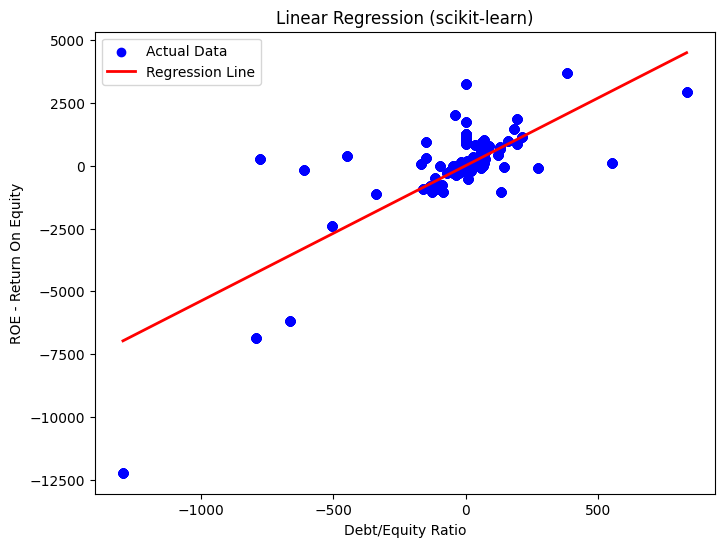

In [11]:
from sklearn.linear_model import LinearRegression

ratio_df.columns
relationship_df = ratio_df[['Debt/Equity Ratio', 'ROE - Return On Equity']]
relationship_df = relationship_df.dropna()

# Define X and y
X = relationship_df[["Debt/Equity Ratio"]]  # scikit-learn requires X to be a 2D array
y = relationship_df["ROE - Return On Equity"]

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Get slope (coefficient) and intercept
beta_1 = model.coef_[0]
beta_0 = model.intercept_

# Generate predictions for the regression line
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = model.predict(X_range)

# Plot the data points
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color="blue", label="Actual Data")

# Plot the regression line
plt.plot(X_range, y_pred, color="red", linewidth=2, label="Regression Line")

# Labels and title
plt.xlabel("Debt/Equity Ratio")
plt.ylabel("ROE - Return On Equity")
plt.title("Linear Regression (scikit-learn)")
plt.legend()


# Print R-squared value
r_squared = model.score(X, y)
print(f"R-squared: {r_squared}")

# Predictions
y_pred = model.predict(X)

# Residuals
residuals = y - y_pred

# Degrees of freedom (n - 2 for simple linear regression)
df = len(y) - 2

# Residual standard error (sigma)
sigma = np.sqrt(np.sum(residuals**2) / df)

# Standard error of the slope
SE_beta_1 = sigma / np.sqrt(np.sum((X.values.flatten() - np.mean(X.values.flatten()))**2))

# Compute t-statistic
t_stat = beta_1 / SE_beta_1

# Compute two-tailed p-value
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))

#H0 and Ha
print("Null Hypothesis: There is no significant relationship between Debt to Equity Ratio and Return on Equity.")
print("Alternative Hypothesis: There is a significant relationship between Debt to Equity Ratio and Return on Equity.")
print("Alpha-value is 0.05 ")
# Print results
print(f"Slope (β1): {beta_1}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

print("Conclusion:")
# Interpretation
alpha = 0.05
if p_value < alpha:
    print("The relationship is statistically significant (reject H0) since p-value < alpha.")
else:
    print("The relationship is NOT statistically significant (fail to reject H0) since p-value >= alpha.")

plt.show()

Great! There is a significant relationship between Debt to Equity Ratio and Return on Equity

Pearson correlation coefficient: 0.5111903025830772
P-value: 0.0


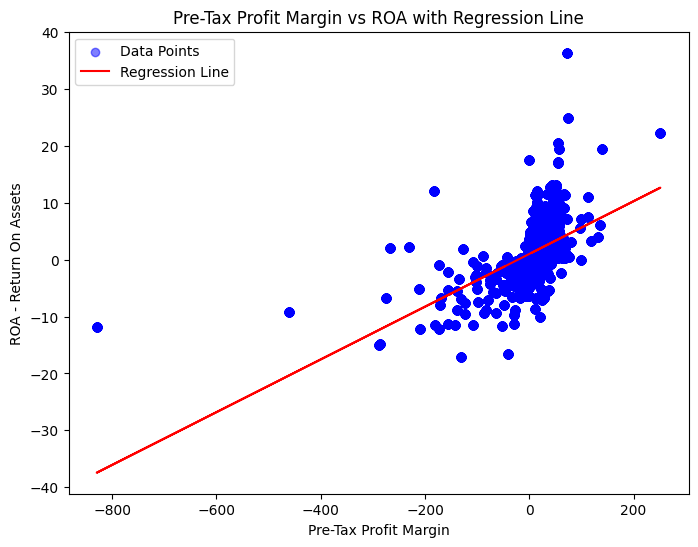

A pearson r of 0.5111903025830772 indicates a moderate linear relationship


In [12]:
# Maybe check if theres relationship between gross profit margin and growth

from scipy.stats import pearsonr

# Extract pretax profit and ROA
pre_tax_profit_margin = ratio_df["Pre-Tax Profit Margin"].dropna()
return_on_assets = ratio_df["ROA - Return On Assets"].dropna()

# x and y need to be same length
common_index = pre_tax_profit_margin.index.intersection(return_on_assets.index)
pre_tax_profit_margin = pre_tax_profit_margin.loc[common_index]
return_on_assets = return_on_assets.loc[common_index]

# calculate pearson correlation
correlation, p_value = pearsonr(pre_tax_profit_margin, return_on_assets)

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")


plt.figure(figsize=(8, 6))
plt.scatter(pre_tax_profit_margin, return_on_assets, alpha=0.5, color='blue', label="Data Points")

# regression line
slope, intercept = np.polyfit(pre_tax_profit_margin, return_on_assets, 1)
regression_line = slope * pre_tax_profit_margin + intercept

# Plot line
plt.plot(pre_tax_profit_margin, regression_line, color='red', label="Regression Line")

plt.title("Pre-Tax Profit Margin vs ROA with Regression Line")
plt.xlabel("Pre-Tax Profit Margin")
plt.ylabel("ROA - Return On Assets")
plt.legend()
plt.show()

print(f"A pearson r of {correlation} indicates a moderate linear relationship")

In [13]:
ratio_df.insert(4, "fiscal quarter", "Q" + ratio_df["quarter"].astype(str) + "-" + ratio_df["year"].astype(str))

### Exploring relationships between changes in financial ratios and changes in share price year-over-year


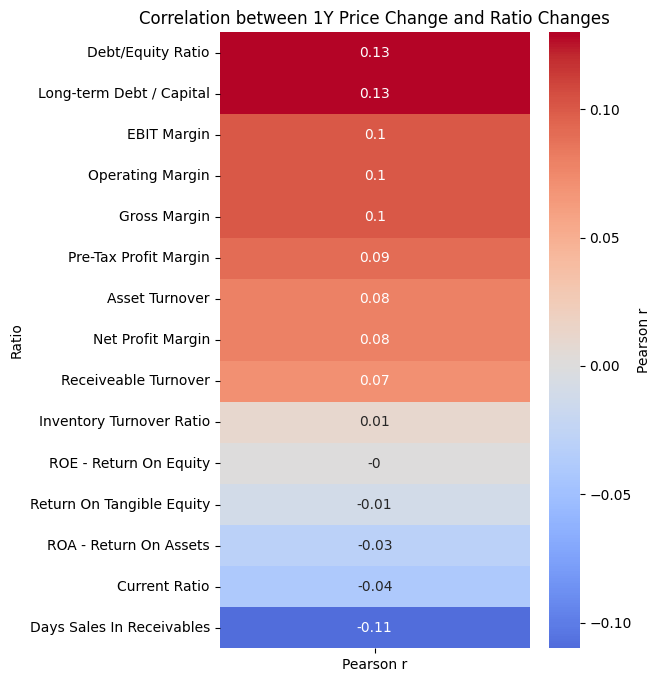

In [14]:
# list of ratio columns to analyze
ratio_columns = [
    "Asset Turnover", "Current Ratio", "Days Sales In Receivables", 
    "Debt/Equity Ratio", "EBIT Margin", "Gross Margin", 
    "Inventory Turnover Ratio", "Long-term Debt / Capital", "Net Profit Margin", 
    "Operating Margin", "Pre-Tax Profit Margin", "ROA - Return On Assets", 
    "ROE - Return On Equity", "Receiveable Turnover", "Return On Tangible Equity"
]

ratio_df["Year"] = ratio_df["Date"].dt.year
grouped = ratio_df.groupby(["Ticker", "Year"]).tail(1).copy()
grouped["1YChange"] = grouped.groupby("Ticker")["Close"].pct_change() * 100

correlation_results = []

for col in ratio_columns:
    
    change_col = f"1Y_{col}_Change"
    grouped[change_col] = grouped.groupby("Ticker")[col].pct_change() * 100
    valid_data = grouped[["1YChange", change_col]].dropna()

    # drop any rows with inf
    valid_data = valid_data.replace([np.inf, -np.inf], np.nan).dropna()

    # calculate Pearson correlation
    r, p = pearsonr(valid_data["1YChange"], valid_data[change_col])
    
    # put it into a dict that will be turned into a dataframe later
    correlation_results.append({
        "Ratio": col,
        "Pearson r": round(r, 2),
        "P-value" : round(p_value, 2)
    })

correlation_df = pd.DataFrame(correlation_results).sort_values("Pearson r", ascending=False)

heatmap_data = correlation_df.set_index("Ratio")[["Pearson r"]]

plt.figure(figsize=(5, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, cbar_kws={"label": "Pearson r"})
plt.title("Correlation between 1Y Price Change and Ratio Changes")
plt.show()

As we can see, there are not any significant correlations between ratio changes and price changes over 1 year. The R values range between -0.11 and 0.13 which indicate little to no correlation.

# Has any industry grown more than the others in the past 5 years?

In [15]:
import pandas as pd
from scipy.stats import ttest_ind

# Ensure 'Date' is in datetime format
ratio_df['Date'] = pd.to_datetime(ratio_df['Date'])

# Filter data for the last 5 years
today = ratio_df['Date'].max()
five_years_ago = today - pd.DateOffset(years=5)
filtered_data = ratio_df[(ratio_df['Date'] >= five_years_ago) & (ratio_df['Date'] <= today)]

# Group by Industry and Date (daily intervals), and calculate average daily returns (Change)
daily_avg_returns = (
    filtered_data.groupby(['Industry', 'Date'])['Change']
    .mean()
    .reset_index()
)

# Calculate the average growth for each industry over 5 years
avg_growth_by_industry = (
    daily_avg_returns.groupby('Industry')['Change']
    .mean()
    .sort_values(ascending=False)
)

# Identify the industry with the largest average growth
industry_with_largest_avg_growth = avg_growth_by_industry.idxmax()
largest_avg_growth = avg_growth_by_industry.max()

# Separate the growth of the largest-growth industry and all other industries
largest_growth_values = daily_avg_returns[daily_avg_returns['Industry'] == industry_with_largest_avg_growth]['Change']
other_growth_values = daily_avg_returns[daily_avg_returns['Industry'] != industry_with_largest_avg_growth]['Change']

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(largest_growth_values, other_growth_values, alternative='greater')

# Display the results
print("Average daily growth over 5 years for each industry:")
print(avg_growth_by_industry)

print(f"\nIndustry with the largest average growth over 5 years: {industry_with_largest_avg_growth}")
print(f"Largest average growth value: {largest_avg_growth}")
avg_growth_excluding_largest = avg_growth_by_industry.drop(industry_with_largest_avg_growth).mean()

# Display the result
print(f"\nAverage of the average growth of all industries excluding the largest growth: {avg_growth_excluding_largest}")

print(f"\nT-statistic: {t_stat}")
print(f"P-value: {p_value}")
print("alpha value =  0.05")

if p_value < 0.05:
    print("The growth of the industry with the largest average growth is significantly different from the average growth of all other industries.")
else:
    print("The growth of the industry with the largest average growth is not significantly different from the average growth of all other industries.")

Average daily growth over 5 years for each industry:
Industry
Materials & Natural Resources        0.130048
Technology & Software                0.106258
Real Estate Services & Consulting    0.097863
Miscellaneous                        0.096448
Telecommunications                   0.091295
Retail                               0.088456
Agriculture                          0.075895
Health Care & Life Sciences          0.075247
Industrials & Manufacturing          0.066194
Transportation & Logistics           0.059278
Media, Entertainment & Leisure       0.050790
Consumer Goods                       0.047960
Financial Services                   0.042838
Real Estate (REITs)                  0.042389
Energy & Utilities                   0.035313
Automotive                           0.033361
Name: Change, dtype: float64

Industry with the largest average growth over 5 years: Materials & Natural Resources
Largest average growth value: 0.13004794740946238

Average of the average growth of all

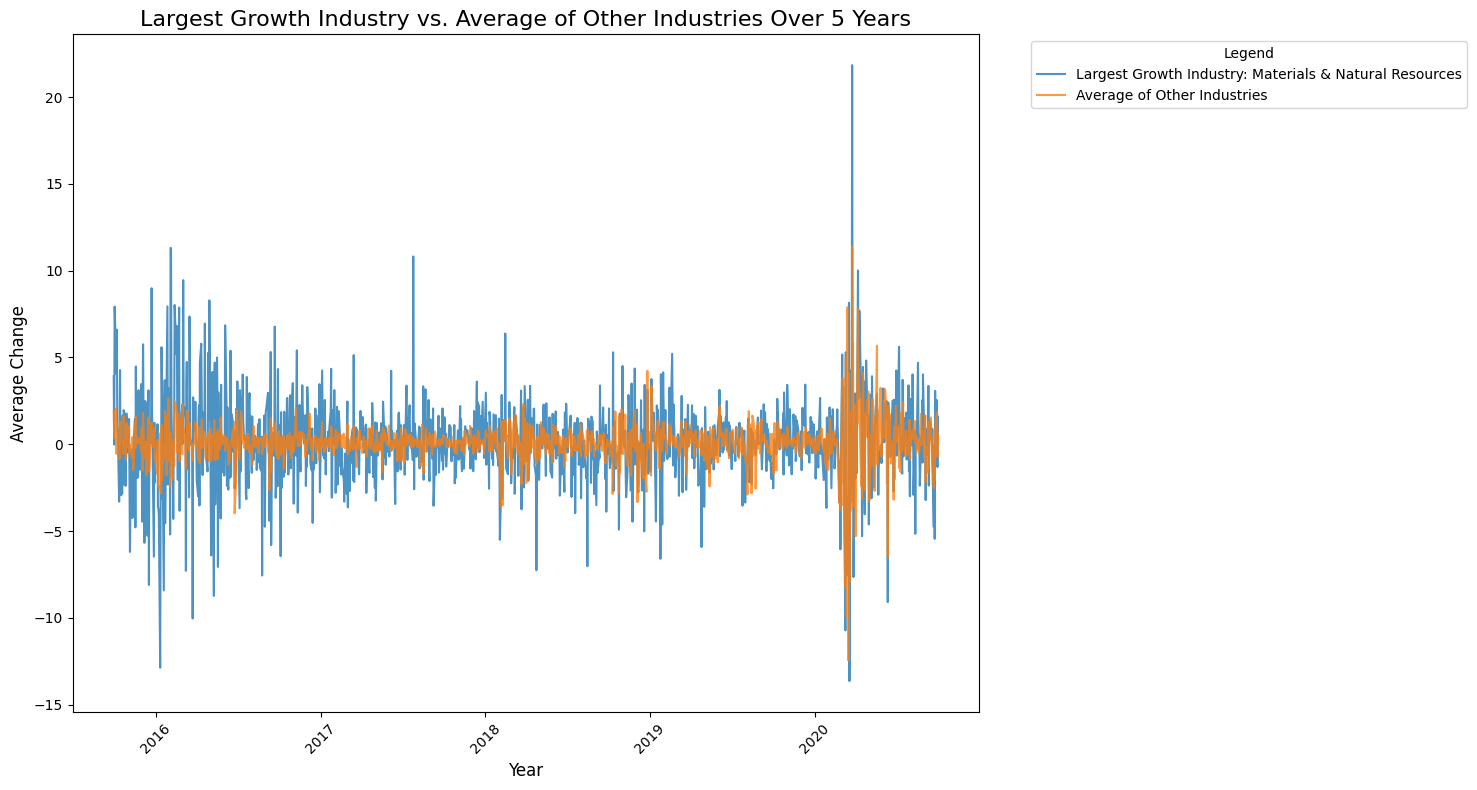

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure 'Date' is in datetime format
ratio_df['Date'] = pd.to_datetime(ratio_df['Date'])

# Filter data for the last 5 years
today = ratio_df['Date'].max()
five_years_ago = today - pd.DateOffset(years=5)
filtered_data = ratio_df[(ratio_df['Date'] >= five_years_ago) & (ratio_df['Date'] <= today)]

# Group by Industry and Date (daily intervals)
daily_avg_returns = (
    filtered_data.groupby(['Industry', 'Date'])['Change']
    .mean()
    .reset_index()
)

# Pivot the data to have industries as columns and days as rows
pivot_data = daily_avg_returns.pivot(index='Date', columns='Industry', values='Change')

# Calculate the average growth over 5 years for each industry
industry_avg_growth = pivot_data.mean()

# Identify the largest-growth industry
largest_growth_industry = industry_avg_growth.idxmax()

# Calculate the average of all other industries
other_industries_avg = pivot_data.drop(columns=largest_growth_industry).mean(axis=1)

# Plot the largest-growth industry and the average of all other industries
plt.figure(figsize=(15, 8))

# Plot the largest-growth industry
plt.plot(pivot_data.index, pivot_data[largest_growth_industry], label=f"Largest Growth Industry: {largest_growth_industry}", alpha=0.8)

# Plot the average of all other industries
plt.plot(pivot_data.index, other_industries_avg, label="Average of Other Industries", alpha=0.8)

# Format the x-axis to show ticks for every year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks at the start of each year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to show the year

# Add labels and legend
plt.title('Largest Growth Industry vs. Average of Other Industries Over 5 Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Change', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

# Daily % change analysis
We will plot a histogram of daily price changes to see if theres any patterns. Through this histogram, we see that for AAPL, its daily returns are unimodal and mostly symmetrical. It slightly resembles a normal distribution. We will pick a random stock, so lets see for Adobe ($ADBE)

0    0.0
Name: Change, dtype: float64


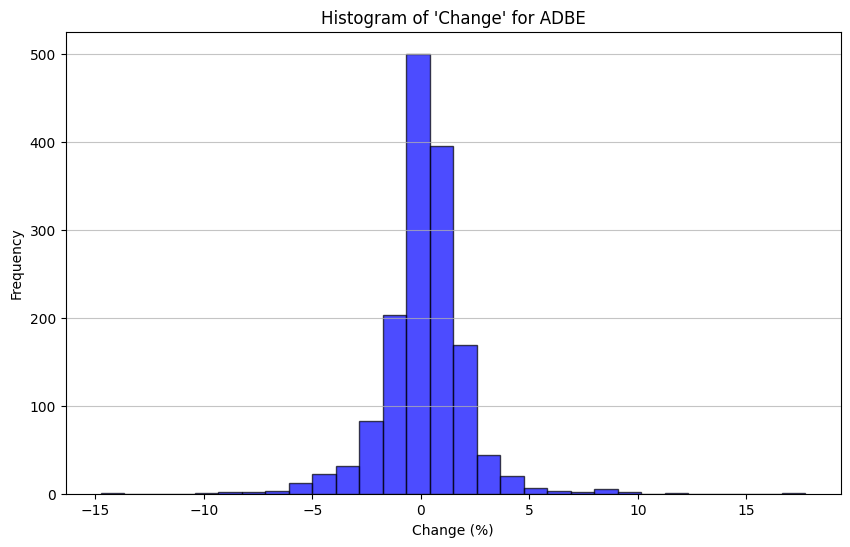

In [17]:
ticker = "ADBE"
aapl_changes = ratio_df[ratio_df["Ticker"] == ticker]["Change"]
print(ratio_df[ratio_df["Ticker"] == ticker]["Change"].mode())
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(aapl_changes, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title(f"Histogram of 'Change' for {ticker}")
plt.xlabel("Change (%)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()



This sort of looks like a normal distribution, but not good enough. We can try to apply a smoothing technique by compounding returns over 30 days.

Now, we compound stock returns up to 30 days for each day and rebase it to 1 so there are no negative values. Instead, negative returns are represented as percentages in decimal (i.e. -10% = Close Price * 0.9)
This histogram looks more like a normal distribution and outliers are not as far spaced apart - the data is more continuous.

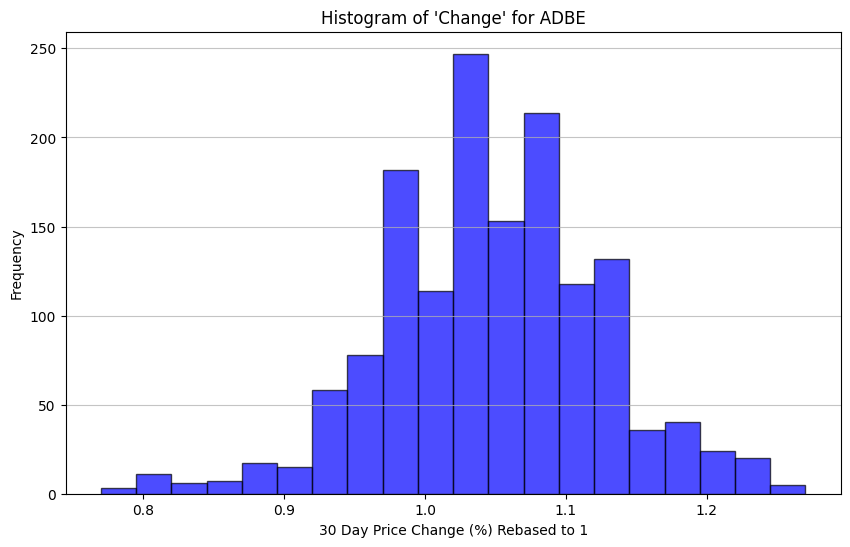

count    1480.000000
mean        1.045115
std         0.077437
min         0.770000
25%         0.990000
50%         1.050000
75%         1.100000
max         1.270000
Name: CompoundedReturn, dtype: float64

In [18]:
REBASE_DAYS = 31

# this gets the growth but over 30 days and rebased to 1. 
# there will not be any negatives and it is visibly smoother and looks more 
# normally distributed
def getDataFrame(df):
    
    # CompoundedReturn is more important than Rebase, you can ignore Rebase for now
    df['Rebase'] = 1
    df['Rebase'] = df['Rebase'].astype(float)
    # compound percentages using cumprod
    # (1 + df['Change'] / 100) converts day changes into a multiplication factor
    df['Rebase'] = 1 * (1 + df['Change'] / 100).cumprod()
    df['CompoundedReturn'] = (1 + df['Change'] / 100).rolling(window=REBASE_DAYS, min_periods=REBASE_DAYS).apply(np.prod)

    df['Rebase'] = df['Rebase'].round(2)
    df['Change'] = df['Change'].round(2)
    df['CompoundedReturn'] = df['CompoundedReturn'].round(2)
    
    # CompoundedReturn column shows the price change in relation to the past 30 days
    # this indicates when trends are overly bullish or bearish, 
    # it also sort of follows a normal distribution

    return df

df = getDataFrame(ratio_df[ratio_df["Ticker"] == ticker].copy())
plt.figure(figsize=(10, 6))
plt.hist(df["CompoundedReturn"], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title(f"Histogram of 'Change' for {ticker}")
plt.xlabel("30 Day Price Change (%) Rebased to 1")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

df["CompoundedReturn"].describe()


This looks a lot like a normal distribution! Although not all stock returns are normally distributed, they are many cases where it does appear to be so, especially after smoothing. You can read more about this concept here: 
[https://www.investopedia.com/articles/investing/100714/using-normal-distribution-formula-optimize-your-portfolio.asp](https://www.investopedia.com/articles/investing/100714/using-normal-distribution-formula-optimize-your-portfolio.asp)

We will use this feature later in our ML experiment.

# Risk adjusted returns by industry

Let's take a look at returns on a risk-adjusted basis now. In this section, we look at the annualized Sharpe ratio, rolling Sharpe ratios across mutliple years, and max drawdown vs average returns for different industries.

The Sharpe ratio compares the expected return of an asset to how risky it is. By calculating the Sharpes of different industries, we can get a better look into which ones will provide better returns on a risk adjusted basis. It's calculated by the below formula. 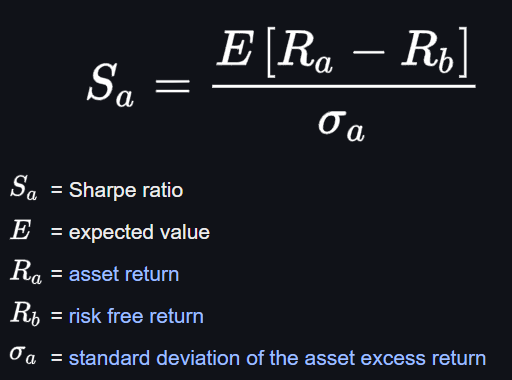

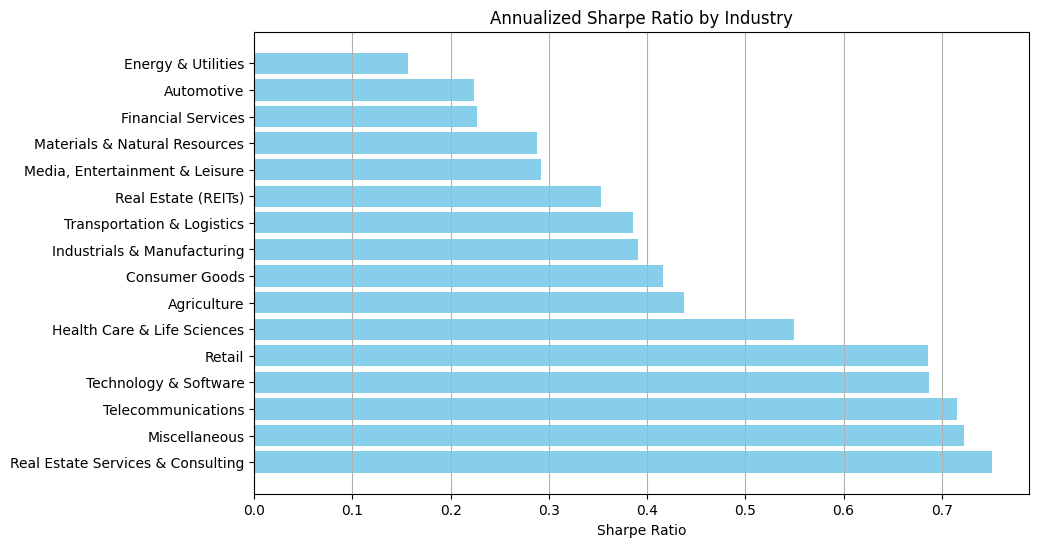

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

risk_free_rate = 0.02  

#calculate Sharpe Ratio and Max Drawdown
def calculate_metrics(df):
    results = []
    
    for industry in df["Industry"].unique():
        industry_data = df[df["Industry"] == industry].copy()
        industry_data["Daily_Return"] = industry_data["Change"] / 100
        industry_data["Excess_Return"] = industry_data["Daily_Return"] - risk_free_rate / 252
        
        # Sharpe Ratio
        sharpe_ratio = (industry_data["Excess_Return"].mean() / 
                        industry_data["Excess_Return"].std()) * np.sqrt(252)

        # Max Drawdown
        cumulative_returns = (1 + industry_data["Daily_Return"]).cumprod()
        peak = cumulative_returns.cummax()
        max_drawdown = ((cumulative_returns - peak) / peak).min()
        
        results.append({
            "Industry": industry,
            "Sharpe Ratio": sharpe_ratio,
            "Max Drawdown": abs(max_drawdown),
            "Average Return": industry_data["Excess_Return"].mean() * 252
        })

    return pd.DataFrame(results)

metrics_df = calculate_metrics(ratio_df)

sharpe_df = metrics_df.sort_values("Sharpe Ratio", ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(sharpe_df["Industry"], sharpe_df["Sharpe Ratio"], color='skyblue')
plt.xlabel("Sharpe Ratio")
plt.title("Annualized Sharpe Ratio by Industry")
plt.grid(axis='x')
plt.show()

Max drawdown shows how great the downside potential is.  By comparing it to the average return, we can get an idea of the trade off between potential losses and gains for different industries

C:\Users\zhong\AppData\Local\Temp\ipykernel_39320\1172181919.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


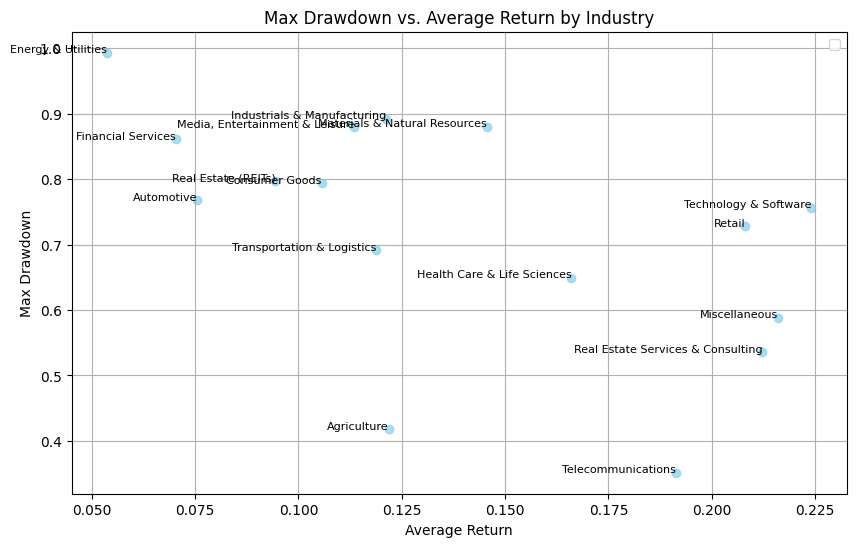

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(metrics_df["Average Return"], metrics_df["Max Drawdown"], color='skyblue', alpha=0.7)
for i, row in metrics_df.iterrows():
    plt.annotate(row["Industry"], (row["Average Return"], row["Max Drawdown"]), fontsize=8, ha='right')
plt.xlabel("Average Return")
plt.ylabel("Max Drawdown")
plt.title("Max Drawdown vs. Average Return by Industry")
plt.legend()
plt.grid()
plt.show()

Another way that we can visualize the Sharpe is with a rolling Sharpe ratio, which shows how the Sharpe changes over time. Let's only look at a single year for now, as it get's a little crazy to look at longer time periods all at once.

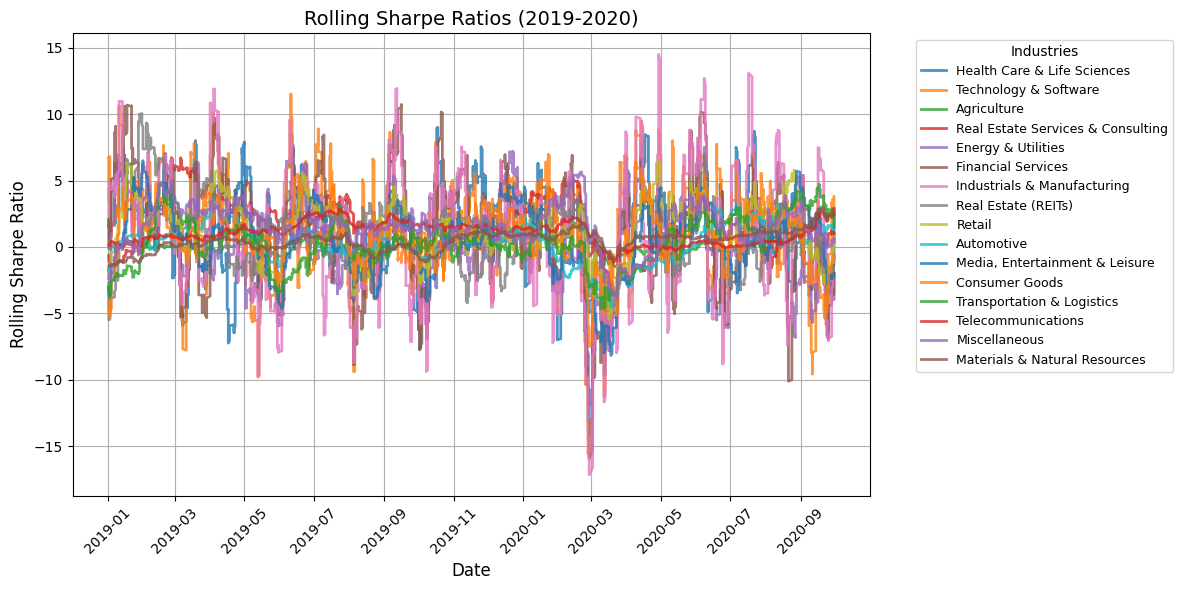

In [34]:
# Rolling Sharpe Ratio
def plot_rolling_sharpe(rolling_sharpe_results, start, end):
    plt.figure(figsize=(12, 6))
    for industry, rolling_sharpe in rolling_sharpe_results.items():
        period_data = rolling_sharpe[(rolling_sharpe.index >= start) & (rolling_sharpe.index < end)]
        if not period_data.empty:
            plt.plot(period_data.index, period_data.values, label=industry, alpha=0.8, linewidth=2)

    plt.title(f"Rolling Sharpe Ratios ({start.year}-{end.year})", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Rolling Sharpe Ratio", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Industries", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid()
    plt.tight_layout()
    plt.show()
    
def compute_rolling_sharpe(df, window=252):
    rolling_sharpe_results = {}

    for industry in df["Industry"].unique():
        industry_data = df[df["Industry"] == industry].copy()
        industry_data["Date"] = pd.to_datetime(industry_data["Date"])
        industry_data.set_index("Date", inplace=True)
        industry_data.sort_index(inplace=True)

        industry_data["Daily_Return"] = industry_data["Change"] / 100
        industry_data["Excess_Return"] = industry_data["Daily_Return"] - risk_free_rate / 252

        rolling_sharpe = (industry_data["Excess_Return"]
                          .rolling(window=window, min_periods=10) 
                          .mean()) / (industry_data["Excess_Return"]
                          .rolling(window=window, min_periods=10)
                          .std()) * np.sqrt(252)

        rolling_sharpe.dropna(inplace=True)

        if rolling_sharpe.empty:
            continue 

        rolling_sharpe_results[industry] = rolling_sharpe

    return rolling_sharpe_results

rolling_sharpe_results = compute_rolling_sharpe(ratio_df)

# Let's only do one year 
start_date = pd.Timestamp('2019-01-01')
end_date = pd.Timestamp('2020-12-31')
plot_rolling_sharpe(rolling_sharpe_results, start_date, end_date)


We can see that some industries fluctuate their Sharpe ratio much more than others, which means that they're less stable investments. Returns on investment are less stable, and potentially more subjective to changes in market condition.

# Part 3: ML 

In [20]:
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler

# leave out the open, high, low - can just pick close
df = df[['Ticker', 'Date','Close', 'Volume', 'CompoundedReturn']].copy()
pd.set_option('display.max_rows', 20)

df.ta.rsi(append=True)
# df.ta.macd(append=True)
df.ta.hma(append=True)
df.ta.ema(append=True, length=10)
df.ta.ema(append=True, length=30)


31545           NaN
31546           NaN
31547           NaN
31548           NaN
31549           NaN
            ...    
33050    476.833032
33051    477.023159
33052    477.764245
33053    478.510423
33054    479.279428
Name: EMA_30, Length: 1510, dtype: float64

In [21]:
# stock volume can be skewed so we need to transform it
df["Volume"] = np.log1p(df["Volume"])
# compounded return is normal so lets standardize it
df["CompoundedReturn"] = (df["CompoundedReturn"] - df["CompoundedReturn"].mean())/ df["CompoundedReturn"].std()
df["CompoundedReturn"]

# normalize stock prices - this will mean indicators based on price will also need to be normalized
close_min = df['Close'].min()
close_max = df['Close'].max()

df["Close"] = (df["Close"] - close_min) / (close_max - close_min)
df["HMA_10"] = (df["HMA_10"] - close_min) / (close_max - close_min)
df["EMA_10"] = (df["EMA_10"] - close_min) / (close_max - close_min)
df["EMA_30"] = (df["EMA_30"] - close_min) / (close_max - close_min)


In [22]:
# Phase idea source: ThinkOrSwim
def phase():
    conditions = [
        (df['Close'] < df['EMA_10']) & (df['Close'] < df['EMA_30']),  # Phase 1 - stock has broken horizontal support and we're waiting for it to find support and enter trend reversal
        (df['Close'] > df['EMA_10']) & (df['Close'] < df['EMA_30']),  # Phase 2 - stock breaking upward, chaning from downtrend to uptrend
        ( ((df['Close'] > df['EMA_10']) & (df['Close'] > df['EMA_30'])) & (df['EMA_10'] > df['EMA_30']) & (df['FallingHull'] == 1 )),   # Phase 4 - still in #3 but showing resistance - warning sign or bullish entry opportunity
        (df['Close'] > df['EMA_10']) & (df['Close'] > df['EMA_30']),  # Phase 3 - strong trending stock
        (df['Close'] < df['EMA_10']) & (df['Close'] > df['EMA_30'])   # Phase 5 - strong trending stock having brief pullback
    ]
    phase_values = [1, 2, 4, 3, 5]
    df['Phase'] = np.select(conditions, phase_values, default=0)

# Idea source / learn more here: https://machinelearning-basics.com/hma-in-python-hull-moving-average/

df['FallingHull'] = (df['HMA_10'] <= df['HMA_10'].shift(1)).astype(int)

phase()
df.dropna(inplace=True)


### Signal Prediction: a simple approach
ML models typically have an noise overfitting problem with stock market data, so we will first try to train a simple LogisticRegression model on the data to classify days as a day to buy or not (0 for no buy, 1 for buy). We need to specify the number of days to look ahead. We can tune this value later to find the optimal days to wait after buying.

Short term price movements are very chaotic and can change day-to-day due to many factors not related to the current price. Therefore, we can judge our ML model based on its accuracy being better than 0.5 (better than just flipping a coin that the next day will be higher or lower than today). 

In [23]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def get_model_accuracy():

    timeseries = TimeSeriesSplit(n_splits=5)

    accuracies = []

    for i, (train_index, test_index) in enumerate(timeseries.split(X)):
        X_train= X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # want to predict class so cant use linear regression
        model = LogisticRegression(random_state=42, max_iter=500)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        
    return (np.mean(accuracies))

trials = 10
TARGET_DAYS_AHEAD = 1
for i in range(1,20):
    # Hyperparameters
    df["FutureReturn"] = df["Close"].shift(-TARGET_DAYS_AHEAD) / df["Close"] - 1
    df["BuySignal"] = np.where(df["FutureReturn"] > 0, 1, 0)

    df.dropna(inplace=True)
    #print(df["BuySignal"].value_counts())

    X = df[['Close', 'Volume', 'CompoundedReturn', 'RSI_14', 'FallingHull', "Phase"]]
    y = df['BuySignal']

    accuracies = []
    for i in range(trials):
        accuracies.append(get_model_accuracy())
    print(f"Mean accuracy when TARGET_DAYS_AHEAD = {TARGET_DAYS_AHEAD}: {np.mean(accuracies)}")
    TARGET_DAYS_AHEAD = TARGET_DAYS_AHEAD + 1
    


Mean accuracy when TARGET_DAYS_AHEAD = 1: 0.5308943089430895
Mean accuracy when TARGET_DAYS_AHEAD = 2: 0.5447154471544715
Mean accuracy when TARGET_DAYS_AHEAD = 3: 0.5363265306122449
Mean accuracy when TARGET_DAYS_AHEAD = 4: 0.5477551020408163
Mean accuracy when TARGET_DAYS_AHEAD = 5: 0.5844262295081968
Mean accuracy when TARGET_DAYS_AHEAD = 6: 0.5604938271604938
Mean accuracy when TARGET_DAYS_AHEAD = 7: 0.552892561983471
Mean accuracy when TARGET_DAYS_AHEAD = 8: 0.5908333333333334
Mean accuracy when TARGET_DAYS_AHEAD = 9: 0.594142259414226
Mean accuracy when TARGET_DAYS_AHEAD = 10: 0.5856540084388187
Mean accuracy when TARGET_DAYS_AHEAD = 11: 0.5999999999999999
Mean accuracy when TARGET_DAYS_AHEAD = 12: 0.6017167381974249
Mean accuracy when TARGET_DAYS_AHEAD = 13: 0.5844155844155845
Mean accuracy when TARGET_DAYS_AHEAD = 14: 0.5781659388646287
Mean accuracy when TARGET_DAYS_AHEAD = 15: 0.5743362831858406
Mean accuracy when TARGET_DAYS_AHEAD = 16: 0.5687499999999999
Mean accuracy when 

Notice that as TARGET_DAYS_AHEAD increases, accuracy tends to increase. Since we are picking stocks from the S&P500, which are the best 500 companies in the US stock market, it could make prices biased towards positive gains.
As we can see, the accuracy ranges from around 0.53 to 0.6 depending on the number of days our labels are looking ahead.
This supervised learning approach using Logistic Regression is a good start, but lets see if it can be improved with a more complicated approach.

## LSTM Stock Change Forecasting - Jupyter Notebook (with Multivariate Attention Ensemble)

This section of ML part implements a Long Short-Term Memory (LSTM) model for stock price prediction using PyTorch. The goal is to predict whether a given stock will increase or decrease in price over a specified number of days. Therefore, the model is essentially a binary classifier. However, since we are working with historical financial data, we need to consider the time series nature of the data. The LSTM model is well-suited for this task as it can learn from sequences of data and capture temporal dependencies. The addition of attention mechanisms allows the model to focus on relevant parts of the input sequence, improving its performance in predicting stock price movements. Therefore, the attention should directly help with the temporal dependencies of the data.  

The final result will display the accuracy of the model on the test data, as well as the F1 score and ROC AUC score.

,Ticker,Date,Close,Volume,CompoundedReturn,RSI_14,HMA_10,EMA_10,EMA_30,FallingHull,Phase,FutureReturn,BuySignal
31575,ADBE,2014-11-13,0.022921,14.755831,0.192223,67.071786,0.023165,0.021140,0.014252,1,4,-0.182657,0
31576,ADBE,2014-11-14,0.022287,14.719932,0.321360,64.709757,0.022783,0.021349,0.014770,1,4,0.436433,1
31577,ADBE,2014-11-17,0.019221,15.051883,-0.324327,54.685563,0.021756,0.020962,0.015058,1,5,0.337734,1
31578,ADBE,2014-11-18,0.021039,14.856918,0.063085,58.765518,0.020939,0.020976,0.015444,1,4,0.149749,1
31579,ADBE,2014-11-19,0.021018,14.601146,0.321360,58.699336,0.020461,0.020984,0.015803,1,4,0.319920,1


Epoch 1/100, Loss: 0.1737
Epoch 2/100, Loss: 0.1738
Epoch 3/100, Loss: 0.1719
Epoch 4/100, Loss: 0.1717
Epoch 5/100, Loss: 0.1725
Epoch 6/100, Loss: 0.1706
Epoch 7/100, Loss: 0.1683
Epoch 8/100, Loss: 0.1694
Epoch 9/100, Loss: 0.1682
Epoch 10/100, Loss: 0.1682
Epoch 11/100, Loss: 0.1685
Epoch 12/100, Loss: 0.1674
Epoch 13/100, Loss: 0.1667
Epoch 14/100, Loss: 0.1641
Epoch 15/100, Loss: 0.1657
Epoch 16/100, Loss: 0.1651
Epoch 17/100, Loss: 0.1637
Epoch 18/100, Loss: 0.1616
Epoch 19/100, Loss: 0.1608
Epoch 20/100, Loss: 0.1632
Epoch 21/100, Loss: 0.1607
Epoch 22/100, Loss: 0.1610
Epoch 23/100, Loss: 0.1601
Epoch 24/100, Loss: 0.1614
Epoch 25/100, Loss: 0.1575
Epoch 26/100, Loss: 0.1555
Epoch 27/100, Loss: 0.1580
Epoch 28/100, Loss: 0.1585
Epoch 29/100, Loss: 0.1561
Epoch 30/100, Loss: 0.1552
Epoch 31/100, Loss: 0.1525
Epoch 32/100, Loss: 0.1532
Epoch 33/100, Loss: 0.1513
Epoch 34/100, Loss: 0.1485
Epoch 35/100, Loss: 0.1485
Epoch 36/100, Loss: 0.1467
Epoch 37/100, Loss: 0.1481
Epoch 38/1

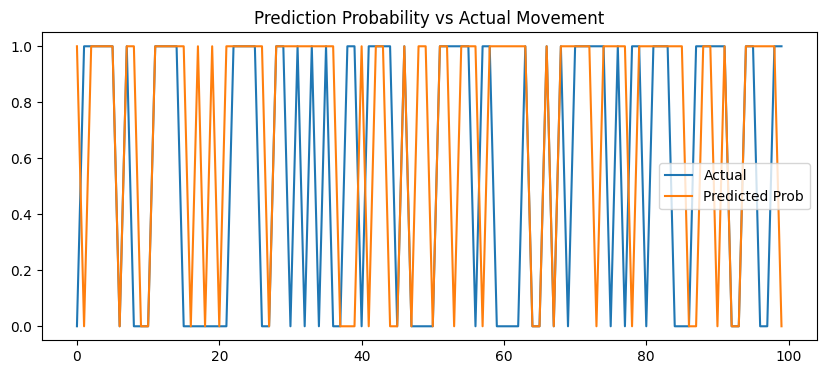

In [24]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# --- Config ---
SEQ_LEN = 30
FORECAST_HORIZON = 2
BATCH_SIZE = 32
EPOCHS = 100
LR = 0.0005
TRAIN_SPLIT = 0.8

# --- Device ---
# If anyone has access to a NVIDIA CUDA GPU, its much faster than CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        return ((1 - pt) ** self.gamma * bce_loss).mean()

# --- Dataset Class ---
def smooth_targets(y, smoothing=0.1):
    return y * (1 - smoothing) + 0.5 * smoothing

class StockDirectionDataset(Dataset):
    def __init__(self, df, forecast_horizon=1, tickers_subset=None):
        self.data = []
        df = df.copy()

        if tickers_subset is not None:
            df = df[df['Ticker'].isin(list(tickers_subset))]

        display(df.head(5))

        df['Prev_Close'] = df.groupby('Ticker')['Close'].shift(1)
        df['LogReturn'] = np.log(df['Close'] / df['Prev_Close'])
        df['Momentum'] = df['Close'] - df['Close'].shift(10)
        df['Target'] = (df.groupby('Ticker')['Close'].shift(-forecast_horizon) > df['Close']).astype(int)
        df['RollingMean_5'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(5).mean())
        df['RollingStd_5'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(5).std())
        df['VolatilityRatio'] = df['RollingStd_5'] / df['RollingMean_5']
        df['PriceAboveEMA'] = df['Close'] - df['EMA_10']
        df['Volume_Change'] = df['Volume'].pct_change()
        df['Volume_MA_5'] = df['Volume'].rolling(5).mean()
        # df['High_Low_Spread'] = df['High'] - df['Low']
        # df['Close_Open_Spread'] = df['Close'] - df['Open']
        df = df.dropna()

        self.scaler_x = StandardScaler()
        self.features = [col for col in df.columns if col not in ['Ticker', 'Date', 'Target', 'Close']]

        for ticker in df['Ticker'].unique():
            group = df[df['Ticker'] == ticker].sort_values('Date').reset_index(drop=True)
            group = group.dropna()

            X_all = self.scaler_x.fit_transform(group[self.features])
            y_all = group['Target'].values

            for i in range(len(group) - SEQ_LEN - forecast_horizon):
                x_seq = X_all[i:i + SEQ_LEN]
                y_orig = y_all[i + SEQ_LEN + forecast_horizon - 1]
                y_target = smooth_targets(y_orig)
                self.data.append((x_seq, y_target, y_orig))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y_smoothed, y_orig = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_smoothed, dtype=torch.float32), torch.tensor(y_orig, dtype=torch.int64)

# --- Attention Module ---
class Attention(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        scores = self.attn(x)
        weights = torch.softmax(scores, dim=1)
        context = (weights * x).sum(dim=1)
        return context

# --- LSTM Classifier ---
class AttentionLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=0.3)
        self.attn = Attention(hidden_dim * 2)
        self.ln = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context = self.attn(lstm_out)
        context = self.ln(context)
        return self.fc(context).squeeze(1)

# --- Training Loop ---
def train_model(model, dataloader, optimizer, criterion, scheduler):
    model.train()
    best_loss = float('inf')
    patience = 10
    trigger = 0

    for epoch in range(EPOCHS):
        total_loss = 0
        for xb, yb, _ in dataloader:  # <-- updated line
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            trigger = 0
        else:
            trigger += 1
            if trigger >= patience:
                print("Early stopping")
                break

# --- Evaluation ---
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, _, yb_orig in dataloader:
            preds = torch.sigmoid(model(xb.to(device))).cpu().numpy()
            preds_binary = np.array(preds > 0.5).astype(int)
            all_preds.extend(preds_binary)
            all_targets.extend(yb_orig.numpy())

    all_preds_binary = np.array(all_preds).flatten()
    accuracy = accuracy_score(all_targets, all_preds_binary)
    f1 = f1_score(all_targets, all_preds_binary)
    roc_auc = roc_auc_score(all_targets, all_preds_binary)

    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
    return all_preds, all_targets

# --- Load & Train ---
tickers_subset = df['Ticker'].unique()
full_dataset = StockDirectionDataset(df, forecast_horizon=FORECAST_HORIZON, tickers_subset=tickers_subset)

train_size = int(len(full_dataset) * TRAIN_SPLIT)
train_dataset, test_dataset = random_split(full_dataset, [train_size, len(full_dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

input_dim = train_dataset[0][0].shape[1]
model = AttentionLSTMClassifier(input_dim).to(device)

criterion = FocalLoss(gamma=2)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

train_model(model, train_loader, optimizer, criterion, scheduler)
preds, targets = evaluate_model(model, test_loader)

plt.figure(figsize=(10, 4))
plt.plot(targets[:100], label='Actual')
plt.plot(preds[:100], label='Predicted Prob')
plt.legend()
plt.title("Prediction Probability vs Actual Movement")
plt.show()


## LSTM Model Analysis
As mentioned above, we aim to build a deep learning model that predicts whether a stock’s price will go up or down in the near future using historical data and technical indicators.

### Data Preparation

* Columns Used: The dataset includes stock tickers, dates, closing prices, volume, and various technical indicators (RSI, EMA, HMA, etc.).
* Target Variable: We define a binary target where 1 = price goes up after `forecast_horizon` days, and 0 = otherwise.
* Manually Added Features: We calculated more features to help capture short-term trends and patterns that might signal price movements:
    - Log Returns
    - Momentum
    - Rolling mean and standard deviation 
    - Volatility ratio
    - Price above EMA
    - Volume change

### Sequential Framing
Sequence Length(`SEQ_LEN`): Each training sample consists of 30 consecutive days of features, which we use to predict the price movement for the next day. This means that for each stock, we create sequences of 30 days of features and the corresponding target value (1 or 0).  

Forecast Horizon: We predict the movement of the stock `n` days into the future, which in this case is set to 2 days.

The goal of this design was to captrue temporal dependencies in the data. The LSTM model will learn to recognize patterns in the sequences of features and use that information to make predictions about future price movements.

### Smoothing the Target
Label smoothing is a regularization technique used in classification tasks. Instead of training the model with hard labels (0 or 1), we use softened versions like 0.05 and 0.95. This helps prevent the model from becoming overly confident and improves generalization.

In binary classification, training with perfect 0 or 1 labels can make the model too certain about its predictions. This becomes a problem when:

* Labels are noisy or uncertain (e.g., stock movement is inherently unpredictable)
* The model starts to overfit on the training data
* We want better probabilistic calibration (i.e., predicted probabilities should reflect actual likelihoods)

Label smoothing mitigates these issues by injecting a bit of ambiguity into the targets. In our code, we call:
````python
def smooth_targets(y, smoothing=0.1):
    return y * (1 - smoothing) + 0.5 * smoothing
````

This blends the original label y with a neutral midpoint (0.5), weighted by the smoothing factor.

For example:

If y = 1:
→ 1 * 0.9 + 0.5 * 0.1 = 0.95

If y = 0:
→ 0 * 0.9 + 0.5 * 0.1 = 0.05

So, instead of telling the model “this is absolutely class 1”, we're saying “this is very likely class 1”. Since stock direction is noisy and full of edge cases where prices barely move or reverse unpredictably. In such contexts, even a correct label might not reflect high certainty. Smoothing acknowledges this by softening the targets. This aligns with our use of probabilistic loss (BCEWithLogitsLoss) and an output that reflects likelihood of upward movement, rather than a strict classification.

### Model Architecture
The model is designed to process sequences of stock data (30 time steps each) and output a probability that the stock will go up after a forecast horizon of 2 days.

1. **LSTM Layer**
````python
self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=0.3)
````
An LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) specialized in learning from sequential data while mitigating the vanishing gradient problem. It processes each time step of the input sequence while keeping track of memory over time, allowing it to model temporal dependencies and trends in the data. We set the `bidirectional=True`because the model has access to both past and future context within the sequence, which can be important in recognizing patterns that are symmetric or spread across time. Dropout helps prevent overfitting by randomly "dropping out" some units during training. Hidden Dim and num_layers control the capacity and depth of the LSTM. Here, we use 2 layers and a hidden dimension of 128.


2. **Attention Mechanism**
````python
self.attn = Attention(hidden_dim * 2)
````
After the LSTM processes the sequence, it outputs a hidden state for each time step. However, not all time steps are equally informative. The attention mechanism assigns weights to each time step, allowing the model to focus on the most relevant parts of the sequence. The Attention module does this by computing a learnable score for each time step, applying a softmax to get a probability distribution (attention weights), and computing a weighted sum (the context vector). This is particularly useful in time series where some historical events matter more than others (e.g., a sudden spike in volume might be more important than a flat day).

3. **Layer Normalization**
````python
self.ln = nn.LayerNorm(hidden_dim * 2)
````
After attention, we apply layer normalization to stabilize and accelerate training. It standardizes the outputs of the attention layer, helping gradients flow more smoothly and improving convergence. This is especially useful in deep networks and recurrent layers like LSTM.

4. **Fully Connected Layer**
````python
self.fc = nn.Sequential(
    nn.Linear(hidden_dim * 2, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 1)
)
````
The output from the attention block is passed to a fully connected feedforward network. The first layer reduces the dimensionality and applies a non-linearity (ReLU) to help the model learn complex patterns. The final layer outputs a single logit, which represents the model's confidence about the stock going up. We don't apply a sigmoid activation here because we use BCEWithLogitsLoss, which combines the sigmoid and binary cross-entropy in a numerically stable way.


**Focal Loss**
````python
class FocalLoss(nn.Module):
    ...
````
In standard binary classification, we might use Binary Cross Entropy (BCE). However, stock movements are often imbalanced (e.g., more flat/down days than big up days), or the model may find some examples easier to learn than others. To address this, we use Focal Loss, a modification of BCE that down-weights easy examples and focuses the learning on harder, misclassified examples. It introduces a tunable parameter gamma (typically 2.0). When a prediction is correct and confident, the loss is small; when it’s wrong or uncertain, the loss is larger. This shifts the model's focus to edge cases or rare patterns that might otherwise be ignored. This is a good choice for stock movement prediction because the signal is noisy and imbalanced, we care more about the uncertain or borderline cases (e.g., sudden shifts, reversals), and we want the model to be robust under volatile or ambiguous market conditions.


### Model Training and Evaluation
Once the model is defined, we move on to training and evaluating its performance. This step involves teaching the model how to make predictions and then testing how well it learned.

#### Training Loop
````python
train_model(model, train_loader, optimizer, criterion, scheduler)
````
The model is trained using mini-batches of data drawn from the training set. For each batch: 

- We pass the inputs through the model to get predictions.
- Compute the loss between the predictions and the (smoothed) targets using Focal Loss.
- Perform backpropagation and update the model's weights using Adam optimizer.
- We clip gradients using clip_grad_norm_ to prevent exploding gradients, which can happen in RNNs.

A learning rate scheduler gradually reduces the learning rate over time (every 5 epochs by 10%), helping the model settle into a better minimum. We also implement early stopping -- if the validation loss doesn’t improve after 10 epochs, training stops to prevent overfitting. 

#### Evaluation Loop
````python
preds, targets = evaluate_model(model, test_loader)
````
Once training is complete, we evaluate the model on the held-out test set. We use the model in inference mode (model.eval()), disabling dropout and stopping gradient computation.

For each batch in the test set:

- We compute the model’s output probabilities (via sigmoid).
- We convert them into binary predictions (1 if probability > 0.5, else 0).
- We compare these predictions to the true labels to compute metrics.

The key evaluation metrics we compute are Accuracy, F1 Score, and ROC AUC. The accuracy gives us a general idea of how well the model is performing, since it is calculated as the number of correct predictions divided by the total number of predictions. The F1 Score is the harmonic mean of precision and recall, which is useful for imbalanced classes. The ROC AUC score measures how well the model ranks positive samples higher than negatives, independent of classification threshold.


### Visualization
````python
plt.plot(targets[:100], label='Actual')
plt.plot(preds[:100], label='Predicted Prob')
````

We visualize the model’s predicted probabilities vs. actual labels over time to inspect how well the model is tracking the signal. This gives us intuition about whether the model is reacting to meaningful patterns or just noise.

### Overall Performance
Overall, the model achieved an accuracy of 0.6318, F1 Score of 0.6891, and ROC AUC of 0.6207. These metrics indicate that the model is able to predict stock price movements with a reasonable level of accuracy, but there is still room for improvement. The F1 Score is particularly important in this context, as it balances precision and recall, which is crucial when dealing with imbalanced classes in stock price movements. The ROC AUC score also suggests that the model has some ability to distinguish between positive and negative samples, but it is not perfect.

### Hypothesis Test to show effeciveness of Model

In [ ]:
# --- Statistical Hypothesis Tests ---
import numpy as np
from scipy.stats import binomtest


# --- 1. Binomial Test: Is accuracy better than random? ---
n_correct = np.sum(np.array(preds) == np.array(targets))
n_total = len(targets)
accuracy = n_correct / n_total
print(f"Model accuracy: {accuracy:.4f}")

# Null: model is correct with probability 0.5 (random guessing)
p_value_binom = binomtest(n_correct, n_total, p=0.5, alternative='greater')
print(f"Binomial test p-value (accuracy > 0.5): {p_value_binom.pvalue:.4g}")

Model accuracy: 0.6040
Binomial test p-value (accuracy > 0.5): 0.0006065


Since the p-value is less than 0.05 we reject the null hypothesis. This means that the LSTM model does a better job at predicting whether a stock price does up or down compared to randomly guessing at a statistically significant level. So the model provides us an idea whether the stock price will go up or down.

# Insights and Conclusions

### 1. Performance Interpretation

- **Accuracy (0.63):**  
  The model correctly classifies about 63% of the samples. This is better than random guessing (which would be 50% for a balanced dataset), showing that the model is learning some meaningful patterns from the data.

- **F1 Score (0.69):**  
  The F1 score is relatively higher than accuracy. This could indicate that class imbalance is present (i.e., more of one class than the other), and the model is handling it reasonably well by balancing precision and recall.

- **ROC AUC (0.62):**  
  The ROC AUC measures the model's ability to distinguish between the two classes. A value of 0.62 is above chance, but not particularly strong. It shows the model has some predictive power, but there's still considerable room for improvement.

---

### 2. Insights

- **Temporal Dependencies:**  
  The use of LSTM and attention seems to have helped the model capture temporal patterns in the stock data, as evidenced by performance being noticeably above random. Attention especially may have helped the model focus on the most relevant parts of the input sequence.

- **Stock Movement Predictability:**  
  Predicting stock prices is notoriously difficult due to their noisy and partially random nature. Achieving any lift above random (50%) is meaningful and shows that the model is extracting some signal from the noise.

- **Improvement over Baseline:**  
  If compared to a naive baseline or a simple logistic regression, this model likely performs better, justifying the use of LSTM and attention mechanisms for this type of time series data.

---

### 3. Limitations & Considerations

- **Moderate Predictive Power:**  
  While above chance, the metrics are still modest. This might not be sufficient for real-world trading, where transaction costs and risk must be considered.

- **Potential Overfitting:**  
  If the model was evaluated on the training set or if there was data leakage, the true out-of-sample performance could be lower.

- **Feature Engineering:**  
  Performance could potentially be improved with better features (e.g., adding technical indicators, macroeconomic data, or sentiment features).

- **Market Efficiency:**  
  The modest performance aligns with the Efficient Market Hypothesis, which posits that it is difficult to consistently outperform the market using historical price data alone.

---

### 4. Conclusions & Next Steps

- The LSTM with attention is able to extract some predictive signal from historical stock price data, as shown by performance above random.
- However, the predictive power is moderate, which is typical for financial time series prediction.
- Further improvements may be possible by:
  - Enhancing feature engineering
  - Tuning the model architecture and hyperparameters
  - Incorporating alternative data sources (news, sentiment, etc.)
  - Ensuring robust cross-validation and out-of-sample testing
